# Application of Transfer Learning Activity Recognition
This notebook shows an application of the SER+STRUT (Mix) approach on a problem of Activity Recognition from accelerometer data. The source dataset comes from Healthy subjects, and the target dataset corresponds to Patients' data

In [1]:
from __future__ import division
import numpy as np
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import graphlab

import sys
sys.path.append('./Doc/')
import TRF #Functions for Transfer Random Forest

### Helper fcns

In [2]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, ['Sit','StairsUp','StairsDw','Stand','Walk'], rotation=45)
    plt.yticks(tick_marks, ['Sit','StairsUp','StairsDw','Stand','Walk'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    #balanced accuracy
def Balanced_acc(ypred,ytest):
    acc_c = 0
    acc_class = np.zeros(5) #the accuracy per class
    for c in np.unique(ytest):
        i = ytest == c
        correct = ypred[i] == ytest[i]
        acc_c += sum(correct)/len(correct)
        acc_class[c] = sum(correct)/len(correct)

    Bacc = acc_c/len(np.unique(ytest))
    return Bacc,acc_class

## Importing Data
you need Graphlab installed to load this dataset

In [3]:
HealthyData = graphlab.SFrame.read_csv('../Datasets/Cbrace/HealthyData.csv',verbose=False)
CBRData = graphlab.SFrame.read_csv('../Datasets/Cbrace/CBRDataTRF.csv',verbose=False)
#SCOData = graphlab.SFrame.read_csv('../Datasets/Cbrace/PatientSCOData.csv',verbose=False)

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1479946794.log


This non-commercial license of GraphLab Create for academic use is assigned to llonini@ricres.org and will expire on October 14, 2017.


In [4]:
CBRData.head(3)

Columns:
	SubjID	int
	Session	int
	Features_  1	float
	Features_  2	float
	Features_  3	float
	Features_  4	int
	Features_  5	int
	Features_  6	int
	Features_  7	int
	Features_  8	float
	Features_  9	float
	Features_ 10	float
	Features_ 11	float
	Features_ 12	float
	Features_ 13	float
	Features_ 14	float
	Features_ 15	float
	Features_ 16	float
	Features_ 17	float
	Features_ 18	int
	Features_ 19	int
	Features_ 20	int
	Features_ 21	int
	Features_ 22	float
	Features_ 23	float
	Features_ 24	float
	Features_ 25	float
	Features_ 26	float
	Features_ 27	float
	Features_ 28	float
	Features_ 29	float
	Features_ 30	float
	Features_ 31	float
	Features_ 32	int
	Features_ 33	int
	Features_ 34	int
	Features_ 35	int
	Features_ 36	float
	Features_ 37	float
	Features_ 38	float
	Features_ 39	float
	Features_ 40	float
	Features_ 41	float
	Features_ 42	float
	Features_ 43	float
	Features_ 44	float
	Features_ 45	float
	Features_ 46	float
	Features_ 47	float
	Features_ 48	float
	Features_ 49	float
	Features_ 50	float
	Features_ 51	float
	Features_ 52	float
	Features_ 53	float
	Features_ 54	float
	Features_ 55	float
	Features_ 56	float
	Features_ 57	float
	Features_ 58	float
	Features_ 59	float
	Features_ 60	float
	Features_ 61	float
	Features_ 62	float
	Features_ 63	float
	Features_ 64	float
	Features_ 65	float
	Features_ 66	float
	Features_ 67	float
	Features_ 68	float
	Features_ 69	float
	Features_ 70	float
	Features_ 71	float
	Features_ 72	float
	Features_ 73	float
	Features_ 74	float
	Features_ 75	float
	Features_ 76	float
	Features_ 77	float
	Features_ 78	float
	Features_ 79	float
	Features_ 80	float
	Features_ 81	float
	Features_ 82	float
	Features_ 83	float
	Features_ 84	float
	Features_ 85	float
	Features_ 86	float
	Features_ 87	float
	Features_ 88	float
	Features_ 89	float
	Features_ 90	float
	Features_ 91	float
	Features_ 92	float
	Features_ 93	float
	Features_ 94	float
	Features_ 95	float
	Features_ 96	float
	Features_ 97	float
	Features_ 98	float
	Features_ 99	float
	Features_100	float
	Features_101	float
	Features_102	float
	Features_103	float
	Features_104	float
	Features_105	float
	Features_106	float
	Features_107	float
	Features_108	float
	Features_109	float
	Features_110	float
	Features_111	float
	Features_112	float
	Features_113	float
	Features_114	float
	Features_115	float
	Features_116	float
	Features_117	float
	Features_118	float
	Features_119	float
	Features_120	float
	Features_121	float
	Features_122	float
	Features_123	float
	Features_124	float
	Features_125	float
	Features_126	float
	Features_127	float
	Features_128	float
	Features_129	float
	Features_130	float
	Features_131	float
	Label	int

Rows: 3

Data:
+--------+---------+--------------+--------------+--------------+--------------+
| SubjID | Session | Features_  1 | Features_  2 | Features_  3 | Features_  4 |
+--------+---------+--------------+--------------+--------------+--------------+
|   1    |    1    |  0.0513823   |    0.6076    |    0.196     |      0       |
|   1    |    1    |  0.0253934   |    0.6076    |    0.1176    |      0       |
|   1    |    1    |  0.0248519   |     0.49     |    0.1176    |      0       |
+--------+---------+--------------+--------------+--------------+--------------+
+--------------+--------------+--------------+--------------+--------------+
| Features_  5 | Features_  6 | Features_  7 | Features_  8 | Features_  9 |
+--------------+--------------+--------------+--------------+--------------+
|     181      |      0       |      0       |   0.112454   |  -0.294669   |
|     178      |      3       |      0       |   0.09832    |  0.0523105   |
|     181      |      0       |      0       |  0.0841223   |   -0.59255   |
+--------------+--------------+--------------+--------------+--------------+
+--------------+--------------+--------------+--------------+--------------+
| Features_ 10 | Features_ 11 | Features_ 12 | Features_ 13 | Features_ 14 |
+--------------+--------------+--------------+--------------+--------------+
|   2.

In [5]:
#SUBJECTS IN THE DATABASE
HealthyCodes = HealthyData['SubjID'].unique()
HealthyCodes = HealthyCodes.sort()
print HealthyCodes
PatientCodes = CBRData['SubjID'].unique()
PatientCodes = PatientCodes.sort()
print PatientCodes

col_names = HealthyData.column_names()
label_cols = col_names[-1:] #the : is used to return a list with one element 
feature_cols = col_names[2:-1]

[51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
[1, 2, 5, 6, 11, 12, 13, 14, 15, 16, 24]


## Train on Healthy (Source) and test on patients (Target)
* Keep one session out (later used for target) and compute mean error
* Use session 1 as target

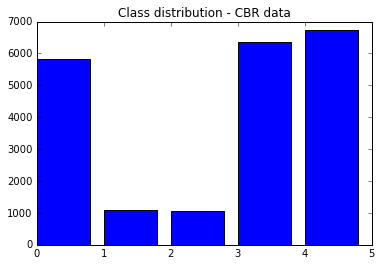

In [6]:
labels = CBRData['Label']
classes,unique_counts = np.unique(labels,return_counts=True)
plt.bar(classes,unique_counts)
plt.title('Class distribution - CBR data')

There is a strong class imbalance in the data

In [7]:
target_session = 1

Xtrain = HealthyData.select_columns(feature_cols).to_numpy()
ytrain = HealthyData.select_columns(label_cols).to_numpy()
ytrain = ytrain.reshape(-1) #to squeeze last dimension and obtain a 1D array
#Train forest on Source
RF = RandomForestClassifier(n_estimators=10,criterion='entropy')
RF = RF.fit(Xtrain,ytrain)

#test on each patient (CBR)
SOacc = np.zeros(len(PatientCodes)) #balanced accuracy per patient
acc_class_subj = [] #accuracy per class for each subject
cmat_subj = [] #confusion matrix for each subject (a list)

k = 0
for s in PatientCodes:
    test = CBRData[(CBRData['SubjID'] == s)  & (CBRData['Session'] != target_session)] #keep out one session (used later for target)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1) #to squeeze last dimension and obtain a 1D array
    Nclasses = len(np.unique(ytest))
    print 'Test on Patient {}, Nclasses test = {}'.format(s,Nclasses)
    print 'Train samples = {}, Test samples = {}'.format(len(ytrain),len(ytest))
    ypred = RF.predict(Xtest)

    #acc = sum(ypred == ytest)/len(ytest)
    #SOacc[k] = acc

    #compute confusion matrix and save results
    #labels=["sitting", "stairs dw", "stairs up", "standing", "walking"])
    Nclass_pred = len(np.unique(ypred))
    cmat = confusion_matrix(ytest, ypred)
    totals = cmat.sum(axis=1)
    totals = np.tile(totals,(max(Nclass_pred,Nclasses),1))
    totals = totals.T
    cmat = cmat/totals
    cmat_subj.append(cmat)
 
    #balanced accuracy
    SOacc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)    
    print 'BAcc = {:.2f}'.format(SOacc[k])
    k = k+1

print '\nmean Bacc Source only = %s'%SOacc.mean()

Test on Patient 1, Nclasses test = 5
Train samples = 8375, Test samples = 1855
BAcc = 0.49
Test on Patient 2, Nclasses test = 5
Train samples = 8375, Test samples = 1228
BAcc = 0.36
Test on Patient 5, Nclasses test = 5
Train samples = 8375, Test samples = 1819
BAcc = 0.47
Test on Patient 6, Nclasses test = 5
Train samples = 8375, Test samples = 1949
BAcc = 0.67
Test on Patient 11, Nclasses test = 5
Train samples = 8375, Test samples = 748
BAcc = 0.41
Test on Patient 12, Nclasses test = 5
Train samples = 8375, Test samples = 713
BAcc = 0.38
Test on Patient 13, Nclasses test = 5
Train samples = 8375, Test samples = 1197
BAcc = 0.43
Test on Patient 14, Nclasses test = 5
Train samples = 8375, Test samples = 1127
BAcc = 0.55
Test on Patient 15, Nclasses test = 5
Train samples = 8375, Test samples = 2671
BAcc = 0.50
Test on Patient 16, Nclasses test = 5
Train samples = 8375, Test samples = 1354
BAcc = 0.64
Test on Patient 24, Nclasses test = 5
Train samples = 8375, Test samples = 1702
BAcc =

<function matplotlib.pyplot.show>

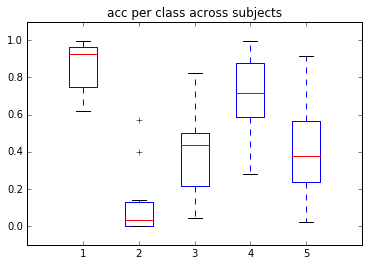

In [8]:
a= np.asarray(acc_class_subj)
plt.boxplot(a)
plt.axis([0,6,-0.1,1.1])
plt.title('acc per class across subjects')
plt.show

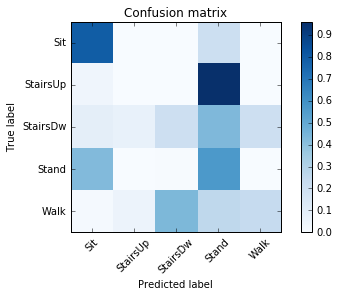

In [9]:
plot_confusion_matrix(cmat_subj[1])

## Train a forest on Target data only
Use 1 session (#1) for each patient as a target

In [10]:
Nsessions_used = 1
TOacc = np.zeros(len(PatientCodes))
TOacc_all = np.zeros((len(PatientCodes),Nsessions_used)) #the accuracy for each target session used as training
Ntarget = np.zeros((len(PatientCodes),Nsessions_used)) #the # of target data points in each target session

cmat_subj = [] #confusion matrix for each subject (a list)
acc_class_subj = [] #accuracy per class for each subject
k = 0
session = 0

for s in PatientCodes:
    target = CBRData[(CBRData['SubjID'] == s) & (CBRData['Session'] == target_session)]
    test = CBRData[(CBRData['SubjID'] == s) & (CBRData['Session'] != target_session)]
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient

    Xtarget = target.select_columns(feature_cols).to_numpy()
    ytarget = target.select_columns(label_cols).to_numpy()
    ytarget = ytarget.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    Ntarget[k,session] = len(ytarget)

    RF = RandomForestClassifier(n_estimators=100,criterion='entropy')
    RF = RF.fit(Xtarget,ytarget)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)

    #compute confusion matrix and save results
    #labels=["sitting", "stairs dw", "stairs up", "standing", "walking"])
    Nclass_pred = len(np.unique(ypred))
    cmat = confusion_matrix(ytest, ypred)
    totals = cmat.sum(axis=1)
    totals = np.tile(totals,(max(Nclass_pred,Nclasses),1))
    totals = totals.T
    cmat = cmat/totals
    cmat_subj.append(cmat)
    
    #balanced accuracy
    TOacc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)    
    
    print 'Patient {}, Nclass test = {}, BAcc - Target only = {:.2f}, Acc per class = {}\n'.format(s,Nclasses,TOacc[k],np.around(acc_class,2))
    k = k+1

print '\nmean acc Target only = {:.2f}'.format(TOacc.mean())

Patient 1, Nclass test = 5, BAcc - Target only = 0.71, Acc per class = [ 0.91  0.53  0.58  0.74  0.81]

Patient 2, Nclass test = 5, BAcc - Target only = 0.52, Acc per class = [ 0.99  0.44  0.32  0.    0.84]

Patient 5, Nclass test = 5, BAcc - Target only = 0.61, Acc per class = [ 0.94  0.01  0.58  0.56  0.95]

Patient 6, Nclass test = 5, BAcc - Target only = 0.68, Acc per class = [ 0.83  0.82  0.37  0.51  0.89]

Patient 11, Nclass test = 5, BAcc - Target only = 0.49, Acc per class = [ 0.39  0.    0.09  1.    0.96]

Patient 12, Nclass test = 5, BAcc - Target only = 0.57, Acc per class = [ 0.62  0.05  0.96  0.27  0.96]

Patient 13, Nclass test = 5, BAcc - Target only = 0.50, Acc per class = [ 0.92  0.11  0.    0.64  0.82]

Patient 14, Nclass test = 5, BAcc - Target only = 0.72, Acc per class = [ 0.95  0.02  0.79  0.92  0.92]

Patient 15, Nclass test = 5, BAcc - Target only = 0.64, Acc per class = [ 1.    0.02  0.23  0.95  0.99]

Patient 16, Nclass test = 5, BAcc - Target only = 0.63, Acc

<function matplotlib.pyplot.show>

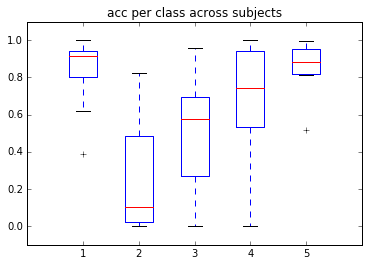

In [11]:
plt.boxplot(np.asarray(acc_class_subj))
plt.title('acc per class across subjects')
plt.axis([0,6,-0.1,1.1])
plt.show

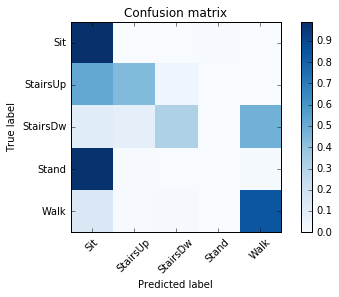

In [12]:
plot_confusion_matrix(cmat_subj[1])

## Use MIX (SER + STRUT) to enhance forest trained on Source with target data from each patient 

In [13]:
#train forest w SER
SERacc = np.zeros(len(PatientCodes)) #to store err when using source + Target with SER
STRUTacc = np.zeros(len(PatientCodes)) #to store err when using source + Target with STRUT
MIXacc = np.zeros(len(PatientCodes)) #to store err when using source + Target with MIX

k = 0
cmat_subj = [] #confusion matrix for each subject (a list)
acc_class_subj = [] #accuracy per class for each subject

#train forest on healthy (Source)
Xtrain = HealthyData.select_columns(feature_cols).to_numpy()
ytrain = HealthyData.select_columns(label_cols).to_numpy()
ytrain = ytrain.reshape(-1) #to squeeze last dimension and obtain a 1D array
RF = RandomForestClassifier(n_estimators=50,criterion='entropy',random_state=0)
RF = RF.fit(Xtrain,ytrain)

for s in PatientCodes:
    #loop through target sessions (use one as target)
    #for session in range(4):
    target = CBRData[(CBRData['SubjID'] == s) & (CBRData['Session'] == target_session)]
    test = CBRData[(CBRData['SubjID'] == s) & (CBRData['Session'] != target_session)]
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test

    Xtarget = target.select_columns(feature_cols).to_numpy()
    ytarget = target.select_columns(label_cols).to_numpy()
    ytarget = ytarget.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)

    #predicting using only source data
    ypred = RF.predict(Xtest)
    #correct = sum(ypred == ytest)
    #SOacc_all[k,session] = correct/len(ytest)

    #balanced accuracy (Source only)
    acc_c = 0
    for c in np.unique(ytest):
        i = ytest == c
        correct = ypred[i] == ytest[i]
        acc_c += sum(correct)/len(correct)
    SOacc[k] = acc_c/len(np.unique(ytest))

    #***SER*** combining source w target data
    newRF = TRF.forest_convert(RF)
    expRF = TRF.forest_SER(newRF,Xtarget,ytarget,C=5) #expand forest on current data (C is the # of classes on the source)
    ypred = np.asarray(map(lambda x:TRF.forest_classify_ensemble(expRF,x),Xtest))
    
    #correct = sum(ypred == ytest)
    #SERacc_all[k,session] = correct/len(ytest)
    
    #balanced accuracy SER
    acc_c = 0
    acc_class = np.zeros(5) #the accuracy per class
    for c in np.unique(ytest):
        i = ytest == c
        correct = ypred[i] == ytest[i]
        acc_c += sum(correct)/len(correct)
    SERacc[k] = acc_c/len(np.unique(ytest))

    
    #***STRUT*** combining source w target data
    STRUT_RF = TRF.STRUT(Xtrain,ytrain,Xtarget,ytarget,n_trees=50,verbos = False)
    ypred = np.asarray(map(lambda x:TRF.forest_classify_ensemble(STRUT_RF,x),Xtest))

    #balanced accuracy
    acc_c = 0
    for c in np.unique(ytest):
        i = ytest == c
        correct = ypred[i] == ytest[i]
        acc_c += sum(correct)/len(correct)
    STRUTacc[k]=acc_c/len(np.unique(ytest))
    
    #*** MIX ****
    #Posteriors from SER and STRUT
    ypredMIX = np.empty(len(ytest))
    for p in range(len(ytest)):
        PSER = TRF.forest_posterior(expRF,Xtest[p]).mean(axis=0)
        PSTRUT = TRF.forest_posterior(STRUT_RF,Xtest[p]).mean(axis=0)
        PMIX = np.array((PSER,PSTRUT)) 
        ypredMIX[p] = np.argmax(PMIX.mean(axis=0))
        
    #balanced accuracy MIX
    acc_c = 0
    for c in np.unique(ytest):
        i = ytest == c
        correct = ypredMIX[i] == ytest[i]
        acc_c += sum(correct)/len(correct)
    MIXacc[k]=acc_c/len(np.unique(ytest))
    

    print 'Test on Patient %s,  '%s
    print '# of classes in test = %s'%Nclasses
    print 'Source samples = %s, Target samples = %s, Test samples = %s'%(len(ytrain),len(ytarget),len(ytest))
    print 'Source Only={:.2f}, Target Only={:.2f}, SER={:.2f}, STRUT={:.2f}, MIX={:.2f}'.format(SOacc[k],TOacc[k],SERacc[k],STRUTacc[k],MIXacc[k])
    
    k = k+1

print '\nmean Acc - Source only = %s'%SOacc.mean()
print 'mean Acc - Target only = %s'%TOacc.mean()
print 'mean Acc - SER = %s'%SERacc.mean()
print 'mean Acc - STRUT = %s'%STRUTacc.mean()
print 'mean Acc - MIX = %s'%MIXacc.mean()

/Users/luca/anaconda/lib/python2.7/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Test on Patient 1,  
# of classes in test = 5
Source samples = 8375, Target samples = 501, Test samples = 1855
Source Only=0.49, Target Only=0.71, SER=0.63, STRUT=0.69, MIX=0.72
Test on Patient 2,  
# of classes in test = 5
Source samples = 8375, Target samples = 230, Test samples = 1228
Source Only=0.37, Target Only=0.52, SER=0.41, STRUT=0.38, MIX=0.46
Test on Patient 5,  
# of classes in test = 5
Source samples = 8375, Target samples = 305, Test samples = 1819
Source Only=0.51, Target Only=0.61, SER=0.54, STRUT=0.54, MIX=0.59
Test on Patient 6,  
# of classes in test = 5
Source samples = 8375, Target samples = 297, Test samples = 1949
Source Only=0.65, Target Only=0.68, SER=0.74, STRUT=0.55, MIX=0.77
Test on Patient 11,  
# of classes in test = 5
Source samples = 8375, Target samples = 459, Test samples = 748
Source Only=0.47, Target Only=0.49, SER=0.48, STRUT=0.48, MIX=0.62
Test on Patient 12,  
# of classes in test = 5
Source samples = 8375, Target samples = 474, Test samples = 713

In [14]:
acc = np.vstack((SOacc,TOacc,MIXacc)).T

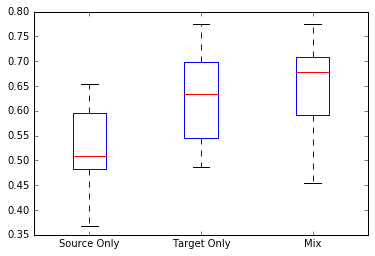

In [15]:
#plt.figure(1)
plt.boxplot(acc)
plt.xticks([1,2,3],['Source Only','Target Only','Mix'])
plt.show()

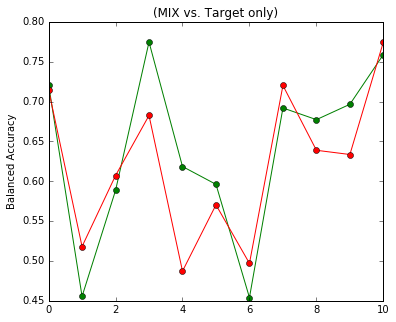

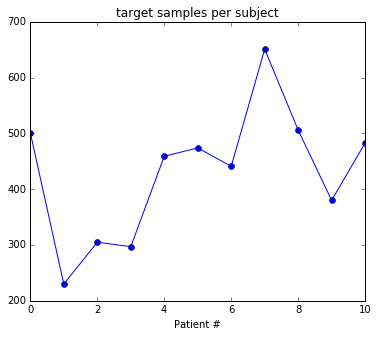

In [16]:
plt.figure(1,figsize=(6,5))
plt.plot(MIXacc,'go-',TOacc,'ro-')
plt.ylabel('Balanced Accuracy')
plt.title('(MIX vs. Target only)')

plt.figure(2,figsize=(6,5))
plt.plot(Ntarget,'-o')
plt.xlabel('Patient #')
plt.title('target samples per subject')
plt.show()